# 章節 8：觀察者偏誤（Observer Bias）

## 8.2 模型

在分析之前，我們需要選擇模型。首先我將乘客的到達情況當作 Poisson 過程（在任何時間點到達的機率是一樣的），乘客到達的頻率 λ 用每分鐘計算。因為我觀察短時間內乘客的情形，而且在每天相同的時段，所以我假設 λ 是不會變動的。

另一方面，火車到達的情況就不適用 Poisson 過程。到波士頓的火車若從底站 Alewift 火車站出發，尖峰時刻約 7-8 分鐘一班車，但到 Kendall 廣場站，兩車班之間的間距大約在 3 到 12 分鐘。

為了抓取兩班次之間的時間區間資料，作者寫了一個從 http://www.mbta.com/rider_tools/developers/ 即時抓資料的程式碼，選取南行到 Kendall 廣場站的車次，並且建立他們到站的時間的資料庫。週間每天下午 4 到 6 點執行程式，總共五天，每天大約紀錄 15 班次。接著我計算兩連續車次的到達時間；班次之間時間區間分佈如下圖，用 z 表示。

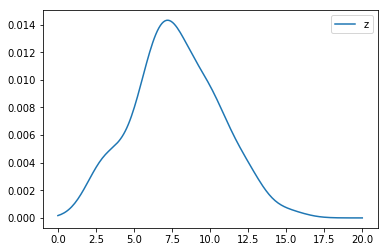

In [27]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import thinkbayes as tb

OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]


def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)

class TruthGaps(tb.Pmf):
    
    def __init__(self, gaps, x=np.linspace(0, 20, 200)):
        super().__init__(x)
        self.kde = gaussian_kde(gaps_min)
        self.make_pmf(x)
        
    def make_pmf(self, x):
        for interval in x:
            self.Set(interval, self.evaluate(interval))
        
        self.Normalize()
        

    def evaluate(self, x):
        return self.kde(x)
            
gaps_min = np.array(OBSERVED_GAP_TIMES)/60.0
z = TruthGaps(gaps_min)
plot_dist(z)
plt.legend(["z"])

plt.show()

如果你站在月台從下午 4 到 6點紀錄車次區間，你將會看到上圖的分佈。但如果你是隨機的到達月台（不考慮列車時刻表），你將會看到不同的分佈。若是一個隨機的旅客看到，列車間時間區間的平均值會遠高於真實的平均。為什麼？因為一個乘客更可能在大的班次區間抵達。舉一個簡單的例子，假設班次的區間只有 5 分鐘或 10 分鐘且概率相同。這種情況下車次區間平均為 7.5 分鐘。

但一個乘客相較於 5 分鐘的區間，更可能遇到 10 分鐘的區間；事實上有兩倍的機會。如果我們調查所有抵達的乘客，會發現 2/3 的乘客是在 10 分鐘區間抵達，只有 1/3 在 5 分鐘的區間抵達。所以透過乘客所看到車次的平均區間是 8.33 分鐘。

這種**觀察者偏差**出現在許多情況下。學生認為教室比他們大，因為大教室有比較多的人。飛機的乘客認為飛機比較滿，因為他們都是在滿機的飛機上。

Students think that classes are bigger than they are because more of them are in the big classes.
Airline passengers think that planes are fuller than they are because more
of them are on full flights.

每種情況下，數值會從真實的分佈依照數值的比例過度取樣。在紅線問題中，班距是兩倍大則被觀察到的可能性也是放大兩倍。所以給訂一個班距的實際分佈，我們可以計算被乘客觀察到的班距分佈。 BiasPmf 方法便是做此計算：

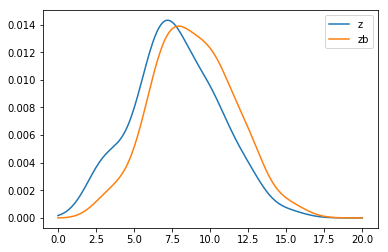

真實資料 z 平均值： [7.77351978]
乘客偏差資料 zb 平均值： [8.89676871]


In [26]:
def BiasPmf(pmf):
    # pmf 是真實資料的分佈
    new_pmf = pmf.Copy()
    
    # 在迴圈裡面，我們對每個數值的機率乘上數值本身，x，也就是被觀察到的可能性與 x 成正比
    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    # 正規化
    new_pmf.Normalize()
    
    #new_pmf 是乘客偏差的分佈
    return new_pmf


zb = BiasPmf(z)

plot_dist(z)
plot_dist(zb)
plt.legend(["z", "zb"])
plt.show()
print("真實資料 z 平均值：", z.Mean())
print("乘客偏差資料 zb 平均值：", zb.Mean())

上圖顯示實際的班距分佈 z ，和乘客觀察到的班距分佈，zb ，代表 z 的偏誤分佈(z biased)。